In [1]:
from foldseek import Foldseek

In [3]:
fs = Foldseek("/Users/donnybertucci/foldseek/bin/foldseek")

In [9]:
query = "/Users/donnybertucci/datasets/venome"
target = "./ext/pdb"
sim = fs.search(query=query, target=target)

In [11]:
sim

[['Gh_comp10207_c0_seq2.pdb', '2afq-assembly1.cif.gz_B', 1.0],
 ['Gh_comp10207_c0_seq2.pdb', '5jdu-assembly1.cif.gz_B', 1.0],
 ['Gh_comp10207_c0_seq2.pdb', '6pxj-assembly2.cif.gz_B', 1.0],
 ['Gh_comp10207_c0_seq2.pdb', '4h6t-assembly1.cif.gz_A', 1.0],
 ['Gh_comp10207_c0_seq2.pdb', '1zpz-assembly1.cif.gz_A', 1.0],
 ['Gh_comp10207_c0_seq2.pdb', '2a0q-assembly3.cif.gz_B', 1.0],
 ['Gh_comp10207_c0_seq2.pdb', '1rd3-assembly1.cif.gz_B', 1.0],
 ['Gh_comp10207_c0_seq2.pdb', '6pxj-assembly1.cif.gz_H', 1.0],
 ['Gh_comp10207_c0_seq2.pdb', '8ase-assembly2.cif.gz_B', 1.0],
 ['Gh_comp10207_c0_seq2.pdb', '4ogy-assembly2.cif.gz_B', 1.0],
 ['Gh_comp10207_c0_seq2.pdb', '6r8x-assembly1.cif.gz_A', 1.0],
 ['Gh_comp10207_c0_seq2.pdb', '1zhp-assembly1.cif.gz_A', 1.0],
 ['Gh_comp10207_c0_seq2.pdb', '5f8t-assembly1.cif.gz_A', 1.0],
 ['Gh_comp10207_c0_seq2.pdb', '5jdu-assembly2.cif.gz_D', 1.0],
 ['Gh_comp10207_c0_seq2.pdb', '3dux-assembly1.cif.gz_H', 1.0],
 ['Gh_comp10207_c0_seq2.pdb', '3r3g-assembly1.cif.gz_B'

In [12]:
len(sim)

165343

In [17]:
def constrain(sim, thresh=1):
	new_res = []
	for o in sim:
		if o[2] >= thresh and o[0] != o[1]:
			new_res.append(o)
	return new_res

simc = constrain(sim)

In [25]:
def topk(sim, k=5):
	d = {}
	for [p1, p2, prob] in simc:
		if p1 in d:
			if len(d[p1]) < k:
				d[p1].append([p2, prob])
		else:
			d[p1] = []
	return d

t = topk(simc)
total = 0
for k in t:
	total += len(t[k])
total

1462

In [26]:
t

{'Gh_comp10207_c0_seq2.pdb': [['5jdu-assembly1.cif.gz_B', 1.0],
  ['6pxj-assembly2.cif.gz_B', 1.0],
  ['4h6t-assembly1.cif.gz_A', 1.0],
  ['1zpz-assembly1.cif.gz_A', 1.0],
  ['2a0q-assembly3.cif.gz_B', 1.0]],
 'Gh_comp1045_c0_seq1.pdb': [['5a3q-assembly1.cif.gz_A', 1.0],
  ['6yso-assembly1.cif.gz_A', 1.0],
  ['2o9j-assembly1.cif.gz_A', 1.0],
  ['8owl-assembly1.cif.gz_A', 1.0],
  ['5zmv-assembly1.cif.gz_A', 1.0]],
 'Gh_comp10466_c0_seq1.pdb': [['6drh-assembly4.cif.gz_H', 1.0],
  ['6drh-assembly3.cif.gz_F', 1.0],
  ['6k93-assembly1.cif.gz_A', 1.0],
  ['4y1w-assembly1.cif.gz_A', 1.0],
  ['6k94-assembly2.cif.gz_B', 1.0]],
 'Gh_comp1063_c0_seq1.pdb': [['6wp4-assembly1.cif.gz_B-2', 1.0],
  ['5x0i-assembly1.cif.gz_D', 1.0],
  ['6wp4-assembly1.cif.gz_D-2', 1.0],
  ['8hmr-assembly1.cif.gz_C', 1.0],
  ['6nu1-assembly1.cif.gz_C-5', 1.0]],
 'Gh_comp1068_c0_seq5.pdb': [['5w1a-assembly1.cif.gz_A', 1.0],
  ['8qyu-assembly1.cif.gz_A', 1.0],
  ['1qvi-assembly1.cif.gz_A', 1.0],
  ['8qyq-assembly2.cif.gz

In [ ]:
# 6wp4-assembly1.cif.gz_B-2
# The letter represents the fasta chain
# The assembly is self explanatory
# 

In [83]:
import requests
from Bio import SeqIO
from io import StringIO

def parse_foldseek_id(og):
    id = og[:4]
    chain = og[og.index("gz_")+3:][0]
    return id, chain

def found_chain(i, id):
    if "|" in i.description:
        parts = i.description.split("|")
        chains = parts[1].lstrip("Chains")
        if id in chains:
            return True
    return False

def fasta_from_pdb(id, chain):
    string = requests.get(f"https://www.rcsb.org/fasta/entry/{id}/display").text
    seq = SeqIO.parse(StringIO(string), format="fasta")

    for i in seq:
        if found_chain(i, chain):
            return i

    raise Exception("Should have found something!")


In [86]:
def flatten_dict(d):
	res = []
	for k in t:
		for sub in t[k]:
			res.append(sub)
	return res

# embed and visualize
pdb_to_embed = []
for k in t:
	for sub in t[k]:
		foldseek_id = sub[0]
		pdb_id, chain = parse_foldseek_id(foldseek_id)
		s = fasta_from_pdb(pdb_id, chain)
		pdb_to_embed.append((foldseek_id, str(s.seq)))

In [88]:
len(pdb_to_embed)

1462

In [93]:
from embed import embed, get_model
from tqdm import tqdm

out = []
layer = 6
m, a = get_model(layer)
for i, s in tqdm(pdb_to_embed):
	out.append(embed(s, m, a, layer))

100%|██████████| 1462/1462 [03:23<00:00,  7.20it/s]


/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-09-21 16:24:15.251926: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


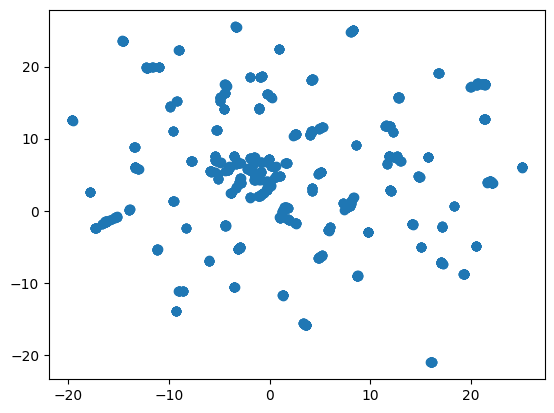

In [94]:
import umap
import matplotlib.pyplot as plt

project = umap.UMAP()
out2D = project.fit_transform(out)
plt.scatter(out2D[:, 0], out2D[:, 1])